# Transformers

Today we will cover the inner-workings of Transformers, an architecture which has been popularized for use in the domain of Natural Language Processing (NLP). This workshop, however, will focus on a more visual example in order to better illustrate how transformers work fundamentally.

#### Import & Set Up Libraries
We begin by importing libraries that we will use throughout the workshop, namely [PyTorch Lightning](https://www.pytorchlightning.ai/).

In [4]:
# Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

# Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from matplotlib.colors import to_rgb
import matplotlib, matplotlib_inline
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.reset_orig()

# tqdm for loading bars
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./models"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


#### Download Pre-Trained Models
The following code chunk downloads two pre-trained models from the author of the tutorial this workshop is modeled after.

In [5]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## The Transformer Architecture

Now, we'll step through implementing the architecture of a Transformer by hand. Due to their popularity, there is already a PyTorch module which implements the architecture, [`nn.Transformer`](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html), but we will build a Transformer from the ground up to hopefully gain a better understanding of how they work.

#### Attention

One of the core concepts powering Transformers is attention. The attention mechanism is a recent, new group of neural network layers that have become increasingly popular recently, particularly in sequence tasks/applications. Its definition varies from paper to paper, but we will consider the following definition throughout this workshop:

> The attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements' keys.

The ultimate goal is to take an average over the features of multiple elements, but rather than weighting each element equally, we want to weight them depending on their actual values. In essence, we want to dynamically decide which inputs we want to "attend" or "focus on" more than others. Generally speaking, the attention mechanism consists of the following four parts:

- **Query:** The query is a feature vector that describes what we are looking for in the sequence, i.e. what would the neural network may want to pay the most attention to.
- **Keys:** For each input element, we have a key which is again a new feature vector. Roughly speaking, this feature vector describes what an element is "offering," or when it may be important. These keys should be designed such that we can identify elements we want to pay attention to based on the query.
- **Values:** For each input element, we also have a value vector. This feature vector is the one we want to average over.
- **Score Function:** To rate which elements we want to pay the most attention to, we need to specify a score function, $f_{attn}$. This function takes the query and a key as input, and outputs the score/attention weight of the query-key pair. It is usually implemented using simple similarity metrics like a dot product, or small multilayer perceptron.

The weights of the average are calculated by a softmax over all score function outputs. We assign a higher weight to those value vectors whose corresponding key is most similar to the query. Using pseudo-math, this can be written as follows:

$$\alpha_i=\frac{exp(f_{attn}(\text{key}_i,\text{query}))}{\sum_jexp(f_{attn}(\text{key}_i,\text{query}))},\ \text{out}=\sum_i\alpha_i\cdot\text{value}_i$$

Visually, we have:

In [1]:
from IPython.display import HTML, display
display(HTML("<img src='img/score_function.svg'>"))

For each word, we have one key and one value vector. The query is compared to all keys with a score function (in this case the dot product) to determine the weights. The softmax is not visualized for simplicity. Finally, the value vectors of all words are averaged using the attention weights.

Most attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined, and what score function is used. The attention applied inside the Transformer architecture is called self-attention. In self-attention, each sequence element provides a key, value, and query. For each element, we have an attention layer which checks the similarity of all sequence elements’ keys based on a query, and returns a different, averaged value vector for each element. We will now go into a bit more detail by first looking at the specific implementation of the attention mechanism which, in the case of Transformers, is scaled dot product attention.

#### Scaled Dot Product Attention

The core concept behind self-attention is scaled dot product attention. Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while still being efficient to compute. Dot product attention takes as input a set of queries $Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$, and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length, and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. The attention value from element $i$ to $j$ is based on its similarity to the query $Q_i$ and key $K_j$, using the dot product as the similarity metric. In math, we calculate dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). Another perspective of this attention mechanism can be visualized as below ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)):

In [27]:
from IPython.display import HTML, display
display(HTML("<img src='img/scaled_dot_product_attn.svg' style='width: 35%;'>"))

One aspect we haven’t discussed yet is the scaling factor, $1/\sqrt{d_k}$, which is crucial to maintain an appropriate variance of attention values after initialization. Remember that we intialize our layers with the intention of having equal variance throughout the model, and hence, $Q$ and $K$ might also have a variance close to $1$. However, performing a dot product over two vectors with a variance $\sigma$ results in a scalar having $d_k$-times higher variance:

$$q_i\sim N(0,\sigma),\ k_i\sim N(0,\sigma)\implies Var\left(\sum_{i=1}^{d_k}q_i\cdot k_i\right)=\sigma\cdot d_k$$

If we do not scale down the variance back to $\sigma$, the softmax over the logits will already saturate to $1$ for one random element and $0$ for all others. The gradients through the softmax will be close to zero so that we can’t learn the parameters appropriately.

The block `Mask (opt.)` in the diagram above represents the optional masking of specific entries in the attention matrix. This is used, for instance, if we stack multiple sequences with different lengths into a batch. To still benefit from parallelization in PyTorch, we pad the sentences to the same length and mask out the padding tokens during the calculation of the attention values. This is usually done by setting the respective attention logits to a very low value.

Now that we understand the details of the scaled dot product attention block, we can write a function below which computes the output features given the queries, keys, and values:

In [6]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
        
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

Note that the code above supports any additional dimensionality in front of the sequence length so that we can also use it for batches. To understand better, let’s generate a few random queries, keys, and value vectors, and calculate the attention outputs:

In [9]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q:\n", q)
print("K:\n", k)
print("V:\n", v)
print("Values:\n", values)
print("Attention:\n", attention)

Global seed set to 42


Q:
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K:
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V:
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values:
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention:
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


#### Multi-Head Attention

Scaled dot product attention allows a network to attend over a sequence. However, there are often multiple different aspects a sequence element may attend to, and a single weighted average would not be able to express this additional complexity. As a result, we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix. Mathematically, we can express this operation as:

$$\text{Multihead}(Q,K,V)=\text{Concat}(\text{head}_1,...,\text{head}_h)W^O$$

where

$$\text{head_i}=\text{Attention}(QW_i^Q,KW_i^K,VW_i^V)$$

We refer to this as the Multi-Head Attention layer with the learnable parameters $W_{1,...,h}^Q\in\mathbb{R}^{D\times d_k}$, $W_{1,...,h}^K\in\mathbb{R}^{D\times d_k}$, $W_{1,...,h}^V\in\mathbb{R}^{D\times d_v}$, and $W^O\in\mathbb{R}^{h\cdot d_k\times d_{out}}$, where $D$ is the input dimensionality. This concept can be expressed visually with the following computational graph ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)):

In [25]:
from IPython.display import HTML, display
display(HTML("<img src='img/multihead_attention.svg' style='width: 35%;'>"))

How do we apply a Multi-Head Attention layer in a neural network, where we don’t have an arbitrary query, key, and value vector as input? Looking at the computation graph above, a simple but effective implementation is to set the current feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ ($B$ being the batch size, $T$ the sequence length, and $d_{\text{model}}$ the hidden dimensionality of $X$). The consecutive weight matrices $W^Q$, $W^K$, and $W^V$ can transform $X$ to  the corresponding feature vectors that represent the queries, keys, and values of the input. Using this approach, we can implement the Multi-Head Attention module below.

In [11]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

One crucial characteristic of multi-head attention is that it is permutation-equivariant with respect to its inputs. That is, if we switch two input elements in the sequence, e.g. $X_1\leftrightarrow X_2$ (neglecting the batch dimension for now), the output is exactly the same besides the elements 1 and 2 switched. Hence, multi-head attention is actually looking at the input not as a sequence, but as a set of elements. This property makes the multi-head attention block and the Transformer architecture extremely powerful and flexible! What if, however, the order of the input is actually important for solving the task, like language modeling? The answer is to encode the position in the input features, which we will take a closer look at later.

#### Transformer Encoder

Next, we will look at how to apply the multi-head attention block inside the Transformer architecture. Originally, the Transformer model was designed for machine translation. Hence, it was built upon an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN. While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding, we will focus here on the encoder part. Many advances in NLP have been made using pure encoder-based Transformer models (if interested, models include the [BERT](https://arxiv.org/abs/1810.04805)-family, the [Vision Transformer](https://arxiv.org/abs/2010.11929), and more). If you understand the encoder architecture, the decoder would be straightforward to implement as well. The full Transformer architecture looks as follows ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)):

In [23]:
from IPython.display import HTML, display
display(HTML("<img src='img/transformer_architecture.svg' style='width: 40%;'>"))

The encoder consists of $N$ identical blocks that are applied in sequence. Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above. The output is added to the original input using a residual connection, and we apply a consecutive Layer Normalization on the sum. Overall, this step can be expressed mathematically as $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ being $Q$, $K$, $V$ input to the attention layer). The residual connection is crucial in the Transformer architecture for two reasons:

1. Similar to Residual Networks, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Thus, the residual connections are crucial for enabling a smooth gradient flow through the model.

2. Without the residual connection, information about the original sequence is lost. Remember that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input features. Removing the residual connections would mean that this information is lost after the first attention layer (after initialization), and with a randomly initialized query and key vector, the output vectors for position have no relation to their original inputs. All outputs of the attention are likely to represent similar information, and the model lacks the ability to distinguish which information came from which input element. An alternative option to residual connection would be to fix at least one head to focus on its original input, but this is very inefficient and does not have the benefit of the improved gradient flow.

Layer normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language applications as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

In addition to the Multi-Head Attention block, a small, fully-connected feed-forward network is included in the model, which is applied to each position separately and identically. Specifically, the model uses a Linear
ReLULinear MLP. The full transformation, including the residual, connection can be expressed as:

$$\text{FFN}(x)=\text{max}(0,xW_1+b_1)W_2+b_2$$
$$x=\text{LayerNorm}(x+\text{FFN}(x))$$

This multilayer perceptron (MLP) adds extra complexity to the model and allows transformations on each sequence element individually. This allows the model to “post-process” the new information added by the previous Multi-Head Attention, and prepare it for the next attention block. Usually, the inner dimensionality of the MLP is $2\times-8\times$ larger than $d_{\text{model}}$, i.e. the dimensionality of the original input $x$. The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

Finally, after exploring all parts of the encoder architecture, we can begin implementing it below. We first implement a single encoder block. Additional to the layers described above, we add dropout layers in the MLP and on the output of the MLP and Multi-Head Attention for regularization.

In [10]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

Based on this block, we can implement a module for the full Transformer encoder. Additionally, we have a forward function that iterates through the sequence of encoder blocks. We also provide a function called `get_attention_maps(...)`, the purpose of which is to return the attention probabilities for all Multi-Head Attention blocks in the encoder. This helps us to understand and, in a sense, explain what's happening inside the model. The attention probabilities should be interpreted with a grain of salt, however, as they do not necessarily reflect the true interpretation of the model.

In [11]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

#### Positional Encoding

We discussed previously that the Multi-Head Attention block is permutation-equivariant, and cannot distinguish whether an input comes before another one in the sequence or not. In tasks like language understanding, however, the position is important for interpreting the input words. The position information can therefore be added via the input features. We could learn an embedding for every possible position, but this would not generalize to a dynamic input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and hopefully generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows:

$$PE_{(pos,\ i)}=\begin{cases}
\text{sin}\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right)&\text{if }i\ \%\ 2=0,\\
\text{cos}\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right)&\text{otherwise.}
\end{cases}$$

$PE_{(pos,\ i)}$ represents the positional encoding at position $pos$ in the sequence, and hidden dimensionality $i$. These values, concatenated for all hidden dimensions, are added to the original input features (in the Transformer visualization above, see “Positional encoding”), and constitute the position information. We distinguish between even ($i\ \%\ 2=0$) and uneven/odd ($i\ \%\ 2=1$) hidden dimensionalities where we apply a sine/cosine respectively. The intuition behind this encoding is that you can represent $PE_{(pos+k,\ :)}$ as a linear function of $PE_{(pos,\ :)}$, which may allow the model to easily attend to relative positions. The wavelengths in different dimensions range from $2\pi$ to $10000\cdot2\pi$.

This positional encoding is implemented below, and adapted from [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model) on Transformers and NLP.

In [14]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

To understand the positional encoding further, we can visualize it using the following code. We will generate an image of the positional encoding over hidden dimensionality and position in a sequence. Each pixel represents the change of the input feature we perform to encode the specific position.

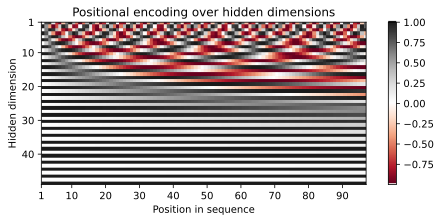

In [15]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

You can clearly see the sine and cosine waves with different wavelengths that encode the position in the hidden dimensions. Specifically, we can look at the sine/cosine wave for each hidden dimension separately, to get a better intuition of the pattern. Below we visualize the positional encoding for the hidden dimensions $1$, $2$, $3$ and $4$.

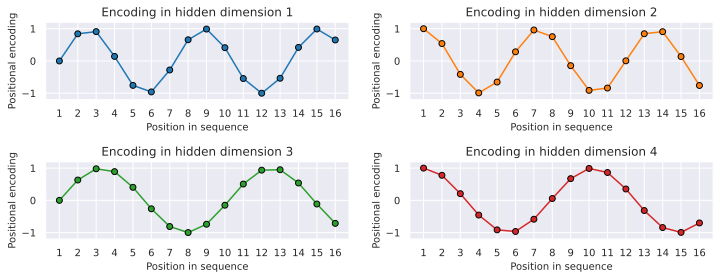

In [16]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

As we can see, the patterns between the hidden dimensions $1$ and $2$ only differ in their starting angles. The wavelength is $2\pi$, hence the repetition after position $6$. The hidden dimensions $3$ and $4$ have about twice the wavelength.

#### Learning Rate Warm-Up

One commonly used technique for training a Transformer is learning rate warm-up. This means that we gradually increase the learning rate from 0 to our originally specified learning rate in the first few iterations. Thus, we slowly start learning instead of taking very large steps from the beginning. In fact, training a deep Transformer without learning rate warm-up can make the model diverge and achieve a much worse performance on training and testing. Take for instance the following plot by [Liu et al. (2019)](https://arxiv.org/pdf/1908.03265.pdf) comparing Adam-vanilla (i.e. Adam without warm-up) versus Adam with warm-up:

In [22]:
from IPython.display import HTML, display
display(HTML("<img src='img/warmup_loss_plot.svg' style='width: 50%;'>"))

The most popular scheduler, right now, is the cosine warm-up scheduler, which combines warm-up with a cosine-shaped learning rate decay. We can implement it below, and visualize the learning rate factor over epochs.

In [28]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

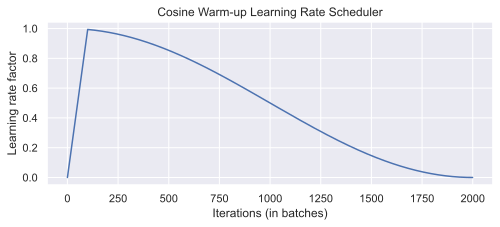

In [29]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In the first 100 iterations, we increase the learning rate factor from 0 to 1, whereas for all later iterations, we decay it using the cosine wave. Pre-implementations of this scheduler can be found in the popular NLP Transformer library [huggingface](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=cosine#transformers.get_cosine_schedule_with_warmup).

#### PyTorch Lightning

Finally, we can embed the Transformer architecture into a PyTorch lightning module. We will implement a template for a classifier based on the Transformer encoder. Thereby, we have a prediction output per sequence element. If we would need a classifier over the whole sequence, the common approach is to add an additional `[CLS]` token to the sequence, representing the classifier token. However, here we focus on tasks where we have an output per element.

Additional to the Transformer architecture, we add a small input network (which maps input dimensions to model dimensions), the positional encoding, and an output network (which transforms output encodings to predictions). We also add the learning rate scheduler, which takes a step each iteration instead of once per epoch. This is needed for the warmup and smooth cosine decay. The training, validation, and test step is left empty for now and will be filled for our task-specific models.

In [30]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

### Experiments

Now that we've finished the implementation of the Transformer architecture, we can start experimenting with it by applying it to various tasks. In this notebook, we will focus on two tasks: parallel Sequence-to-Sequence, and set anomaly detection. The two tasks focus on different properties of the Transformer architecture, and we go through them below.

#### Sequence to Sequence

A Sequence-to-Sequence task represents a task where the input and output are both sequences, not necessarily of the same length. Popular tasks in this domain include machine translation and summarization. For this, we usually have a Transformer encoder for interpreting the input sequence, and a decoder for generating the output in an autoregressive manner. Here, however, we will use a much simpler example using only the encoder. Given a sequence of $N$ numbers between $0$ and $M$, the task is to reverse the input sequence. In Numpy notation, if our input is $x$, the output should be $x$[::-1]. Although this task sounds very simple, RNNs can struggle with it because it requires long-term dependencies. Transformers are built to support such long-term dependencies, thus we expect it to perform adequately.

First, let’s create a dataset class below.

In [31]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

We create an arbitrary number of random sequences of numbers between `0` and `num_categories - 1`. The label is simply the tensor flipped over the sequence dimension. The corresponding data loaders are implemented below.

In [32]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

Let’s look at an arbitrary sample of the dataset:

In [33]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9])
Labels:     tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9])


During training, we pass the input sequence through the Transformer encoder and predict the output for each input token. We use the standard Cross-Entropy loss to do this. Every number is represented as a one-hot vector. Remember that representing the categories as single scalars decreases the expressiveness of the model extremely as $0$ and $1$ are not more closely related than $0$ and $9$ in our example. An alternative to a one-hot vector is using a learned embedding vector as provided by the PyTorch module `nn.Embedding`. However, using a one-hot vector with an additional linear layer, as in our case, has the same effect as an embedding layer (`self.input_net` maps a one-hot vector to a dense vector, where each row of the weight matrix represents the embedding for a specific category).

To implement the training dynamic, we create a new class inheriting from `TransformerPredictor` that overrides the training, validation and test step functions.

In [36]:
class ReversePredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [23]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=10,
                         gradient_clip_val=5,
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
        trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [24]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
c:\users\epman\pycharmprojects\2021-fall-w04-transformers\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:678: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Missing logger folder: models\ReverseTask\lightning_logs
c:\users\epman\pycharmprojects\2021-fall-w04-transformers\venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [25]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


In [26]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

In [27]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

In [28]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

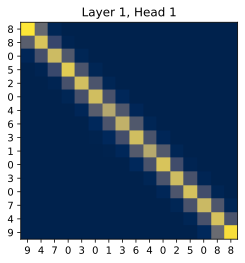

In [29]:
plot_attention_maps(data_input, attention_maps, idx=0)

In [30]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)



Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz to ./data\cifar-100-python.tar.gz


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [31]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)
# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to ./models\hub\checkpoints\resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [32]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [33]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: torch.Size([50000, 512])
Test:  torch.Size([10000, 512])


In [34]:
## Split train into train+val
# Get labels from train set
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [35]:
class SetAnomalyDataset(data.Dataset):

    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size-1 # The set size is here the size of correct images
        self.train = train

        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()


    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets


    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly.
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1

        # Sample images from the class determined above
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices


    def __len__(self):
        return self.img_feats.shape[0]


    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1

        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

In [42]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=64, shuffle=True,  drop_last=True, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=64, shuffle=False, drop_last=False)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=64, shuffle=False, drop_last=False)

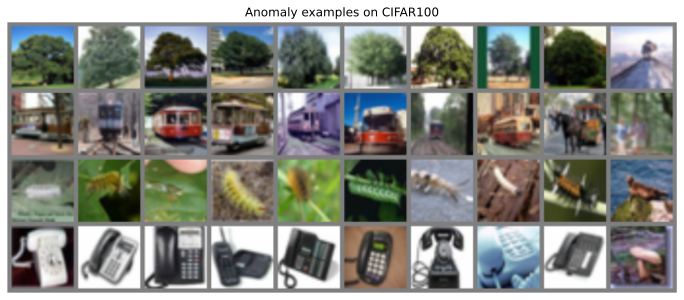

In [43]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS

    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

In [44]:
class AnomalyPredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        img_sets, _, labels = batch
        preds = self.forward(img_sets, add_positional_encoding=False) # No positional encodings as it is a set, not a sequence!
        preds = preds.squeeze(dim=-1) # Shape: [Batch_size, set_size]
        loss = F.cross_entropy(preds, labels) # Softmax/CE over set dimension
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc, on_step=False, on_epoch=True)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [45]:
def train_anomaly(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=100,
                         gradient_clip_val=2,
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = AnomalyPredictor(max_iters=trainer.max_epochs*len(train_anom_loader), **kwargs)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, test_dataloaders=train_anom_loader, verbose=False)
    val_result = trainer.test(model, test_dataloaders=val_anom_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_anom_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "train_acc": train_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [46]:
anomaly_model, anomaly_result = train_anomaly(input_dim=train_anom_dataset.img_feats.shape[-1],
                                              model_dim=256,
                                              num_heads=4,
                                              num_classes=1,
                                              num_layers=4,
                                              dropout=0.1,
                                              input_dropout=0.1,
                                              lr=5e-4,
                                              warmup=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
c:\users\epman\pycharmprojects\2021-fall-w04-transformers\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:678: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: models\SetAnomalyTask\lightning_logs


Found pretrained model, loading...


c:\users\epman\pycharmprojects\2021-fall-w04-transformers\venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:376: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
c:\users\epman\pycharmprojects\2021-fall-w04-transformers\venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [47]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 96.43%
Val accuracy:   96.48%
Test accuracy:  94.24%


In [49]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
    preds = anomaly_model.forward(inp_data, add_positional_encoding=False)
    preds = F.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permut input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:,permut]
    perm_preds = anomaly_model.forward(perm_inp_data, add_positional_encoding=False)
    perm_preds = F.softmax(perm_preds.squeeze(dim=-1), dim=-1)

assert (preds[:,permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

AssertionError: Predictions are not permutation equivariant

In [ ]:
attention_maps = anomaly_model.get_attention_maps(inp_data, add_positional_encoding=False)
predictions = preds.argmax(dim=-1)

In [ ]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

In [ ]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)

In [ ]:
visualize_prediction(mistakes[-1])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
    print(f"Image {i}: {100.0*p:4.2f}%")